In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.cluster import MeanShift
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import MeanShift, estimate_bandwidth

In [2]:
df = pd.read_csv("merged.csv", header=0)
df

,Agent,TotalCalls,UsefulCalls,ConnectedCallTimeMins,UsefulCallTimeMins,ConnectedCalls,MedianConnectedCallTime,TotalEmails,Booking,TotalRevenue,AverageTicket,TotalNewLeads,GrossCRLead_per,L2A_per,A2PA_per,PaidApps,AllApps
0,Adriana Hernandez,214.0,214.0,29.300000,80.316667,9.0,2.600000,257.0,11540.0,11540.0,11540.000000,117,0.854701,14.529915,5.882353,1,17
1,Alberto Conde,3159.0,3055.0,1468.833333,2174.333333,205.0,4.066667,3148.0,149103.0,129934.0,8283.500000,1319,1.364670,8.263836,16.513761,18,109
2,Alejandra Almonte,3742.0,3737.0,835.833333,1437.683333,215.0,2.983333,2171.0,114173.0,109101.0,2594.840909,1342,3.278689,10.357675,31.654676,44,139
3,Amanda Campos,6012.0,5911.0,1397.650000,2470.483333,315.0,3.383333,3937.0,31020.0,23486.0,2068.000000,1916,0.782881,5.584551,14.018692,15,107
4,Amanda Da Rosa,449.0,445.0,235.183333,313.683333,54.0,2.833333,13.0,0.0,0.0,0.000000,109,0.000000,7.339450,0.000000,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,Veronica Miquilena,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,2,0.000000,0.000000,0.000000,0,0
138,Verónica Miquilena,8929.0,8857.0,4049.766667,6431.733333,825.0,3.033333,8.0,341709.0,253494.0,6973.653061,3557,1.377565,4.723081,29.166667,49,168
139,Victor Fernandes,6066.0,5999.0,2432.750000,4517.466667,513.0,2.966667,25.0,240254.0,156266.0,15015.875000,2373,0.674252,3.497682,19.277108,16,83
140,Wolfang Freites,6783.0,6651.0,2904.733333,4789.350000,480.0,3.766667,5294.0,72799.0,66826.0,2141.147059,2168,1.568266,5.258303,29.824561,34,114


### Data preprocessing common to all models

In [3]:
# Select features and drop useless features
X = df.drop(
    [
        "Agent",
        "ConnectedCalls",
        "ConnectedCallTimeMins",
        "MedianConnectedCallTime",
        "TotalRevenue",
        "AverageTicket",
        "TotalCalls",
    ],
    axis=1,
)

categorical_cols = X.select_dtypes(include=["object"]).columns
numerical_cols = X.select_dtypes(include=["number"]).columns

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

### K-Means Clustering
- Description: Partitions data into K distinct clusters based on distance to the centroid of the cluster.
- Use Cases: Customer segmentation, image compression.
- Pros: Simple, scalable, and efficient for large datasets.
- Cons: Assumes clusters are spherical, sensitive to initial placement of centroids.

Hyperparameters:
- n_clusters: Number of clusters.
- Tuning: Use the Elbow method to plot inertia vs. number of clusters and look for the “elbow” point. Alternatively, use the Silhouette score to determine the optimal number of clusters.

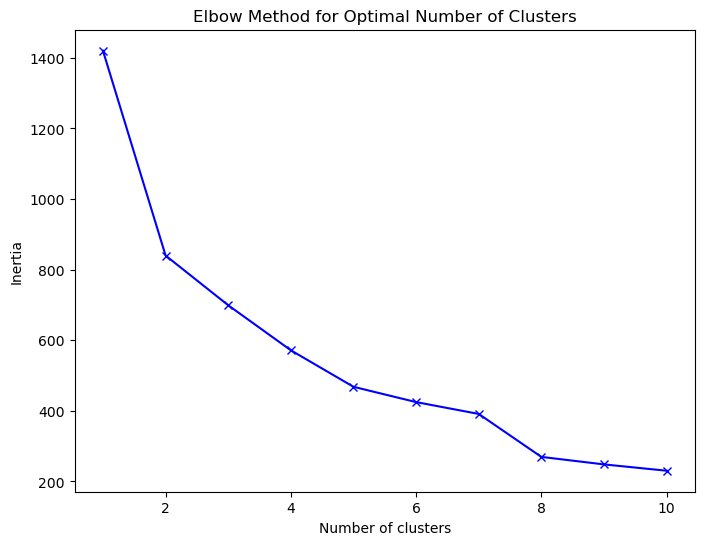

In [4]:
df_kmeans = df

# Determine the optimal number of clusters using the elbow method
inertia = []
K = range(1, 11)
for k in K:
    pipeline = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("kmeans", KMeans(n_clusters=k, random_state=42)),
        ]
    )
    pipeline.fit(df_kmeans)
    inertia.append(pipeline["kmeans"].inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(K, inertia, "bx-")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal Number of Clusters")
plt.show()

In [5]:
# Fit the KMeans model with the optimal number of clusters (e.g., 3)
optimal_k = 2  # You can determine this from the elbow plot
pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("kmeans", KMeans(n_clusters=optimal_k, random_state=42)),
    ]
)
pipeline.fit(df_kmeans)

# Add the cluster labels to the original data
df_kmeans["cluster"] = pipeline["kmeans"].labels_

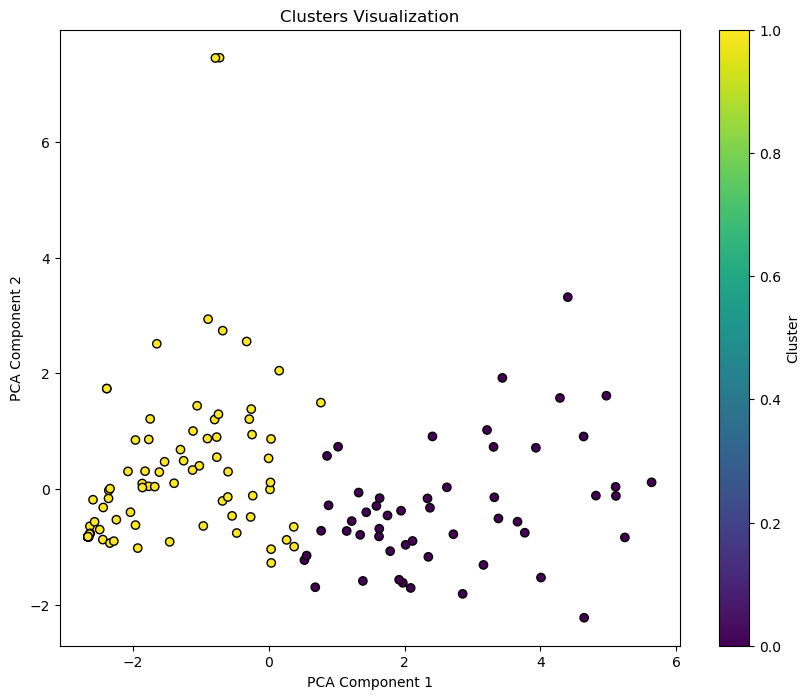

In [6]:
# PCA for 2D visualization
pca = PCA(n_components=2)
data_pca = pca.fit_transform(pipeline["preprocessor"].transform(df))

# Plot the resulting clusters
plt.figure(figsize=(10, 8))
plt.scatter(
    data_pca[:, 0],
    data_pca[:, 1],
    c=df["cluster"],
    cmap="viridis",
    marker="o",
    edgecolor="k",
)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Clusters Visualization")
plt.colorbar(label="Cluster")
plt.show()

In [7]:
df_kmeans

,Agent,TotalCalls,UsefulCalls,ConnectedCallTimeMins,UsefulCallTimeMins,ConnectedCalls,MedianConnectedCallTime,TotalEmails,Booking,TotalRevenue,AverageTicket,TotalNewLeads,GrossCRLead_per,L2A_per,A2PA_per,PaidApps,AllApps,cluster
0,Adriana Hernandez,214.0,214.0,29.300000,80.316667,9.0,2.600000,257.0,11540.0,11540.0,11540.000000,117,0.854701,14.529915,5.882353,1,17,1
1,Alberto Conde,3159.0,3055.0,1468.833333,2174.333333,205.0,4.066667,3148.0,149103.0,129934.0,8283.500000,1319,1.364670,8.263836,16.513761,18,109,1
2,Alejandra Almonte,3742.0,3737.0,835.833333,1437.683333,215.0,2.983333,2171.0,114173.0,109101.0,2594.840909,1342,3.278689,10.357675,31.654676,44,139,1
3,Amanda Campos,6012.0,5911.0,1397.650000,2470.483333,315.0,3.383333,3937.0,31020.0,23486.0,2068.000000,1916,0.782881,5.584551,14.018692,15,107,1
4,Amanda Da Rosa,449.0,445.0,235.183333,313.683333,54.0,2.833333,13.0,0.0,0.0,0.000000,109,0.000000,7.339450,0.000000,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,Veronica Miquilena,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,2,0.000000,0.000000,0.000000,0,0,1
138,Verónica Miquilena,8929.0,8857.0,4049.766667,6431.733333,825.0,3.033333,8.0,341709.0,253494.0,6973.653061,3557,1.377565,4.723081,29.166667,49,168,0
139,Victor Fernandes,6066.0,5999.0,2432.750000,4517.466667,513.0,2.966667,25.0,240254.0,156266.0,15015.875000,2373,0.674252,3.497682,19.277108,16,83,1
140,Wolfang Freites,6783.0,6651.0,2904.733333,4789.350000,480.0,3.766667,5294.0,72799.0,66826.0,2141.147059,2168,1.568266,5.258303,29.824561,34,114,0


In [8]:
data_preprocessed = preprocessor.fit_transform(df_kmeans)
# Example: Determining the optimal number of clusters using silhouette score
range_n_clusters = range(2, 11)
best_n_clusters = 2
best_score = -1
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(data_preprocessed)
    score = silhouette_score(data_preprocessed, kmeans.labels_)
    if score > best_score:
        best_score = score
        best_n_clusters = n_clusters

print(
    f"Optimal number of clusters: {best_n_clusters} with a silhouette score of {best_score}"
)

Optimal number of clusters: 2 with a silhouette score of 0.42052942592961384


### Hierarchical Clustering:
- Description: Builds a tree of clusters using either a bottom-up or top-down approach.
- Use Cases: Gene expression data, hierarchical document clustering.
- Pros: No need to specify the number of clusters initially.
- Cons: Computationally intensive, not suitable for large datasets.

Hyperparameters:
- n_clusters: Number of clusters.
- Tuning: Use the dendrogram to visually inspect where to cut the tree. Alternatively, use the Silhouette score for different numbers of clusters.
- linkage: Method to calculate the distance between clusters (e.g., ‘ward’, ‘complete’, ‘average’, ‘single’).
- Tuning: Try different linkage methods and evaluate the clustering performance using metrics like the Silhouette score.

In [9]:
df_hc = df

# Fit the preprocessor to the data and transform it
data_preprocessed = preprocessor.fit_transform(df_hc)

# Perform hierarchical clustering
hc = AgglomerativeClustering(n_clusters=5, metric="euclidean", linkage="complete")
hc.fit(data_preprocessed)

# Add the cluster labels to the original data
df_hc["cluster"] = hc.labels_

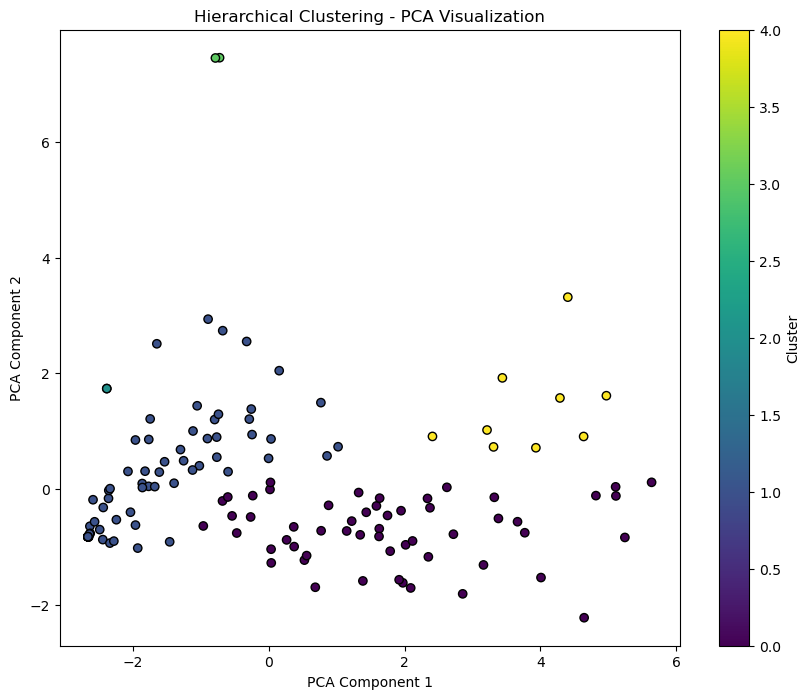

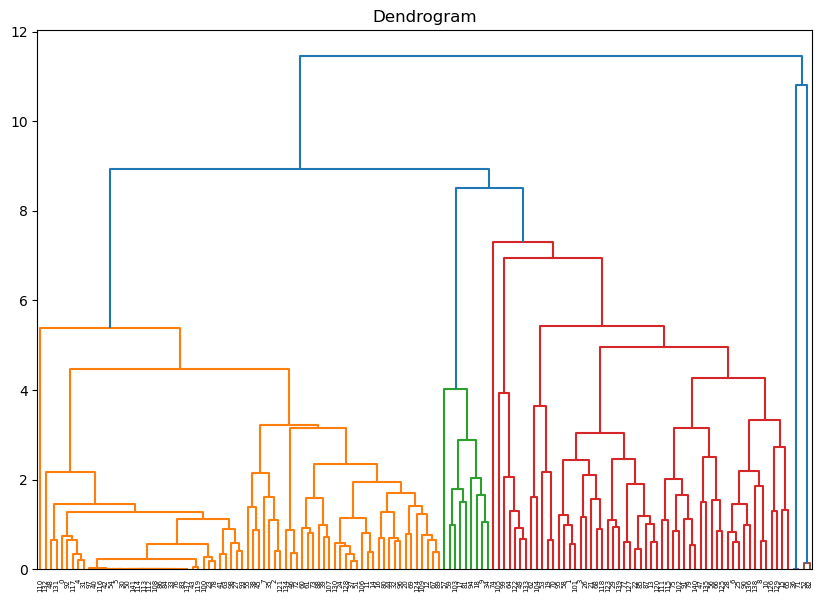

In [10]:
# PCA for 2D visualization
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_preprocessed)

# Plot the resulting clusters
plt.figure(figsize=(10, 8))
plt.scatter(
    data_pca[:, 0],
    data_pca[:, 1],
    c=df_hc["cluster"],
    cmap="viridis",
    marker="o",
    edgecolor="k",
)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Hierarchical Clustering - PCA Visualization")
plt.colorbar(label="Cluster")
plt.show()

# Dendrogram to visualize the hierarchical clustering
plt.figure(figsize=(10, 7))
plt.title("Dendrogram")
dend = shc.dendrogram(shc.linkage(data_preprocessed, method="complete"))
plt.show()

In [11]:
df_hc

,Agent,TotalCalls,UsefulCalls,ConnectedCallTimeMins,UsefulCallTimeMins,ConnectedCalls,MedianConnectedCallTime,TotalEmails,Booking,TotalRevenue,AverageTicket,TotalNewLeads,GrossCRLead_per,L2A_per,A2PA_per,PaidApps,AllApps,cluster
0,Adriana Hernandez,214.0,214.0,29.300000,80.316667,9.0,2.600000,257.0,11540.0,11540.0,11540.000000,117,0.854701,14.529915,5.882353,1,17,1
1,Alberto Conde,3159.0,3055.0,1468.833333,2174.333333,205.0,4.066667,3148.0,149103.0,129934.0,8283.500000,1319,1.364670,8.263836,16.513761,18,109,0
2,Alejandra Almonte,3742.0,3737.0,835.833333,1437.683333,215.0,2.983333,2171.0,114173.0,109101.0,2594.840909,1342,3.278689,10.357675,31.654676,44,139,1
3,Amanda Campos,6012.0,5911.0,1397.650000,2470.483333,315.0,3.383333,3937.0,31020.0,23486.0,2068.000000,1916,0.782881,5.584551,14.018692,15,107,0
4,Amanda Da Rosa,449.0,445.0,235.183333,313.683333,54.0,2.833333,13.0,0.0,0.0,0.000000,109,0.000000,7.339450,0.000000,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,Veronica Miquilena,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,2,0.000000,0.000000,0.000000,0,0,1
138,Verónica Miquilena,8929.0,8857.0,4049.766667,6431.733333,825.0,3.033333,8.0,341709.0,253494.0,6973.653061,3557,1.377565,4.723081,29.166667,49,168,0
139,Victor Fernandes,6066.0,5999.0,2432.750000,4517.466667,513.0,2.966667,25.0,240254.0,156266.0,15015.875000,2373,0.674252,3.497682,19.277108,16,83,0
140,Wolfang Freites,6783.0,6651.0,2904.733333,4789.350000,480.0,3.766667,5294.0,72799.0,66826.0,2141.147059,2168,1.568266,5.258303,29.824561,34,114,0


In [12]:
# Example: Determining the optimal linkage method using silhouette score
linkage_methods = ["ward", "complete", "average", "single"]
best_linkage = "ward"
best_score = -1
for linkage in linkage_methods:
    hc = AgglomerativeClustering(n_clusters=3, linkage=linkage)
    hc.fit(data_preprocessed)
    score = silhouette_score(data_preprocessed, hc.labels_)
    if score > best_score:
        best_score = score
        best_linkage = linkage

print(f"Optimal linkage method: {best_linkage} with silhouette score: {best_score}")

Optimal linkage method: complete with silhouette score: 0.575170440161353


### DBSCAN (Density-Based Spatial Clustering of Applications with Noise):
- Description: Groups together points that are closely packed, marking as outliers points that lie alone in low-density regions.
- Use Cases: Spatial data, anomaly detection.
- Pros: Can find arbitrarily shaped clusters, robust to noise.
- Cons: Requires careful selection of parameters (epsilon, min_samples).

Hyperparameters:
- eps: Maximum distance between two samples for one to be considered as in the neighborhood of the other.
- Tuning: Use a k-distance graph to identify the optimal epsilon value.
- min_samples: Number of samples in a neighborhood for a point to be considered as a core point.
- Tuning: Start with the default value and adjust based on domain knowledge and data distribution.

In [32]:
df_dbscan = df

# Fit the preprocessor to the data and transform it
data_preprocessed = preprocessor.fit_transform(df_dbscan)

# Perform DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(data_preprocessed)

# Add the cluster labels to the original data
df_dbscan["cluster"] = dbscan.labels_

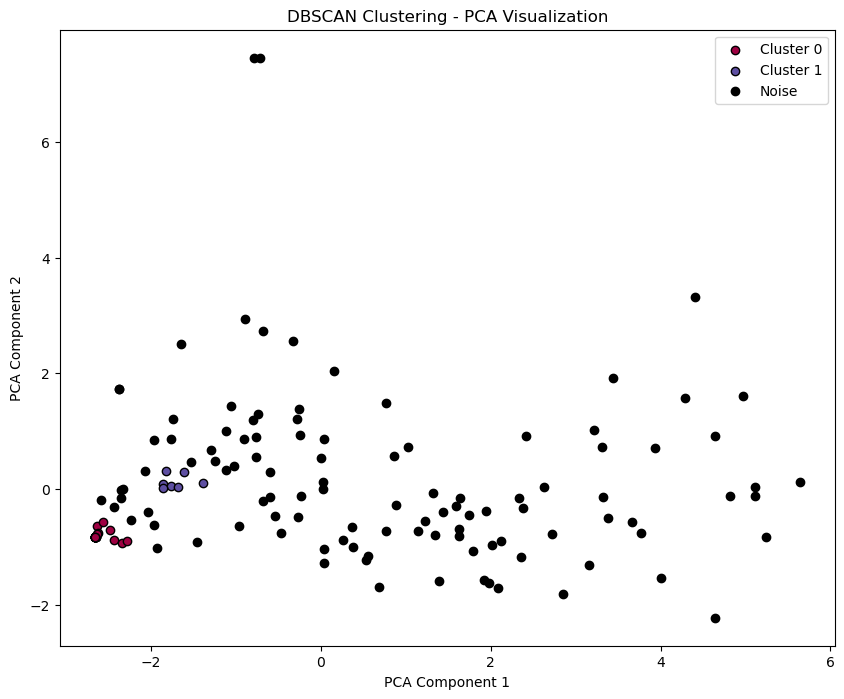

In [33]:
# PCA for 2D visualization
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_preprocessed)

# Plot the resulting clusters
plt.figure(figsize=(10, 8))
unique_labels = set(dbscan.labels_)
colors = [plt.cm.Spectral(each / max(unique_labels)) for each in unique_labels]

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise
        col = [0, 0, 0, 1]
    class_member_mask = dbscan.labels_ == k
    xy = data_pca[class_member_mask]
    plt.scatter(
        xy[:, 0],
        xy[:, 1],
        c=[col],
        label=f"Cluster {k}" if k != -1 else "Noise",
        edgecolor="k",
    )

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("DBSCAN Clustering - PCA Visualization")
plt.legend()
plt.show()

In [15]:
df_dbscan

,Agent,TotalCalls,UsefulCalls,ConnectedCallTimeMins,UsefulCallTimeMins,ConnectedCalls,MedianConnectedCallTime,TotalEmails,Booking,TotalRevenue,AverageTicket,TotalNewLeads,GrossCRLead_per,L2A_per,A2PA_per,PaidApps,AllApps,cluster
0,Adriana Hernandez,214.0,214.0,29.300000,80.316667,9.0,2.600000,257.0,11540.0,11540.0,11540.000000,117,0.854701,14.529915,5.882353,1,17,-1
1,Alberto Conde,3159.0,3055.0,1468.833333,2174.333333,205.0,4.066667,3148.0,149103.0,129934.0,8283.500000,1319,1.364670,8.263836,16.513761,18,109,-1
2,Alejandra Almonte,3742.0,3737.0,835.833333,1437.683333,215.0,2.983333,2171.0,114173.0,109101.0,2594.840909,1342,3.278689,10.357675,31.654676,44,139,-1
3,Amanda Campos,6012.0,5911.0,1397.650000,2470.483333,315.0,3.383333,3937.0,31020.0,23486.0,2068.000000,1916,0.782881,5.584551,14.018692,15,107,-1
4,Amanda Da Rosa,449.0,445.0,235.183333,313.683333,54.0,2.833333,13.0,0.0,0.0,0.000000,109,0.000000,7.339450,0.000000,0,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,Veronica Miquilena,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,2,0.000000,0.000000,0.000000,0,0,0
138,Verónica Miquilena,8929.0,8857.0,4049.766667,6431.733333,825.0,3.033333,8.0,341709.0,253494.0,6973.653061,3557,1.377565,4.723081,29.166667,49,168,-1
139,Victor Fernandes,6066.0,5999.0,2432.750000,4517.466667,513.0,2.966667,25.0,240254.0,156266.0,15015.875000,2373,0.674252,3.497682,19.277108,16,83,-1
140,Wolfang Freites,6783.0,6651.0,2904.733333,4789.350000,480.0,3.766667,5294.0,72799.0,66826.0,2141.147059,2168,1.568266,5.258303,29.824561,34,114,-1


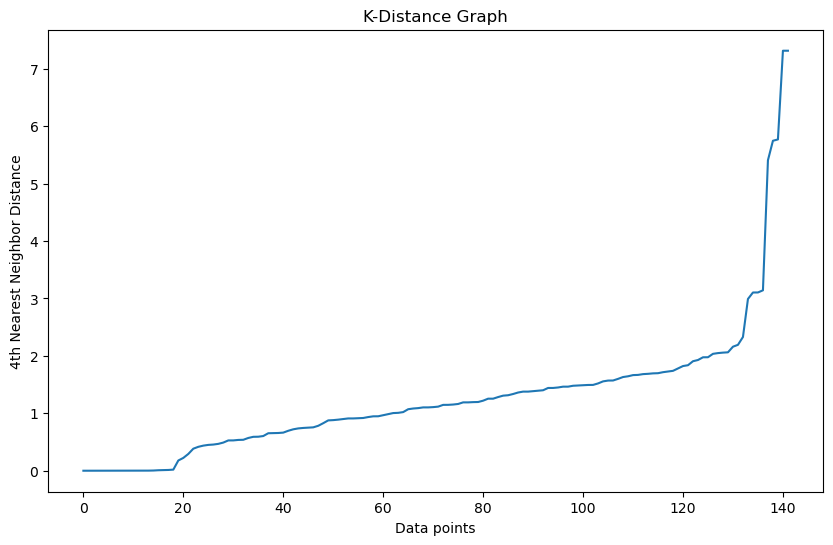

DBSCAN(eps=0.2)

In [27]:
# Example: Determining the optimal eps value using k-distance graph
nearest_neighbors = NearestNeighbors(n_neighbors=5)
nearest_neighbors.fit(data_preprocessed)
distances, indices = nearest_neighbors.kneighbors(data_preprocessed)

distances = np.sort(distances[:, 4], axis=0)
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.xlabel("Data points")
plt.ylabel("4th Nearest Neighbor Distance")
plt.title("K-Distance Graph")
plt.show()

# Choose an appropriate eps value from the graph
eps = 0.2
dbscan = DBSCAN(eps=eps, min_samples=5)
dbscan.fit(data_preprocessed)

### Gaussian Mixture Models (GMM):
- Description: Assumes data is generated from a mixture of several Gaussian distributions with unknown parameters.
- Use Cases: Soft clustering, anomaly detection.
- Pros: Can model clusters with different shapes and sizes.
- Cons: Computationally expensive, assumes Gaussian distribution of clusters.

Hyperparameters:
- n_components: Number of mixture components.
- Tuning: Use metrics like BIC (Bayesian Information Criterion) and AIC (Akaike Information Criterion) to determine the optimal number of components.

In [36]:
df_gmm = df

# Fit the preprocessor to the data and transform it
data_preprocessed = preprocessor.fit_transform(df_gmm)

# Perform GMM clustering
gmm = GaussianMixture(n_components=5, random_state=42)
gmm.fit(data_preprocessed)
labels = gmm.predict(data_preprocessed)

# Add the cluster labels to the original data
df_gmm["cluster"] = labels

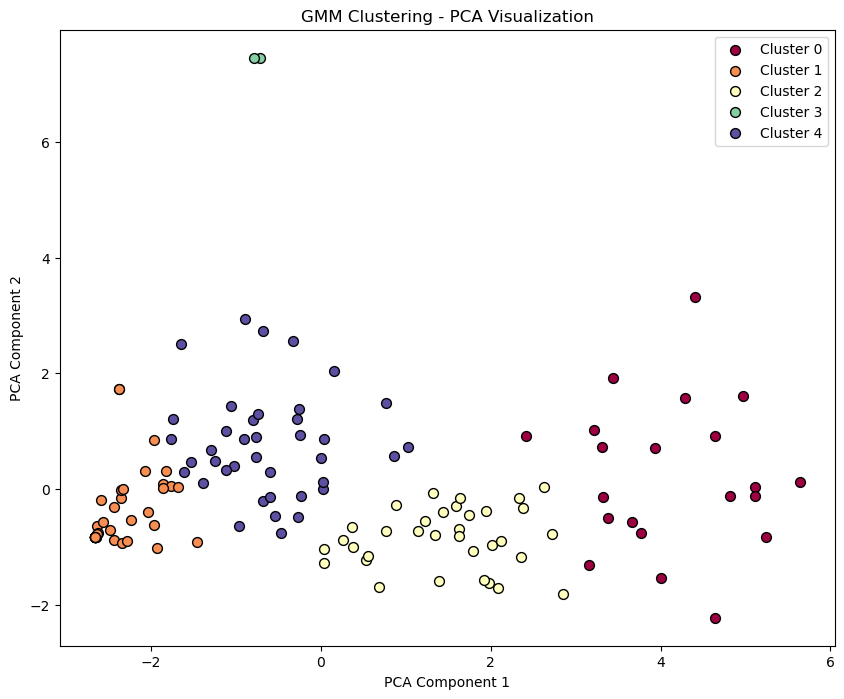

In [37]:
# PCA for 2D visualization
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_preprocessed)

# Plot the resulting clusters
plt.figure(figsize=(10, 8))
unique_labels = set(labels)
colors = [plt.cm.Spectral(each / max(unique_labels)) for each in unique_labels]
for k, col in zip(unique_labels, colors):
    class_member_mask = labels == k
    xy = data_pca[class_member_mask]
    plt.scatter(xy[:, 0], xy[:, 1], c=[col], label=f"Cluster {k}", edgecolor="k", s=50)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("GMM Clustering - PCA Visualization")
plt.legend()
plt.show()

In [38]:
df_gmm

,Agent,TotalCalls,UsefulCalls,ConnectedCallTimeMins,UsefulCallTimeMins,ConnectedCalls,MedianConnectedCallTime,TotalEmails,Booking,TotalRevenue,AverageTicket,TotalNewLeads,GrossCRLead_per,L2A_per,A2PA_per,PaidApps,AllApps,cluster
0,Adriana Hernandez,214.0,214.0,29.300000,80.316667,9.0,2.600000,257.0,11540.0,11540.0,11540.000000,117,0.854701,14.529915,5.882353,1,17,1
1,Alberto Conde,3159.0,3055.0,1468.833333,2174.333333,205.0,4.066667,3148.0,149103.0,129934.0,8283.500000,1319,1.364670,8.263836,16.513761,18,109,4
2,Alejandra Almonte,3742.0,3737.0,835.833333,1437.683333,215.0,2.983333,2171.0,114173.0,109101.0,2594.840909,1342,3.278689,10.357675,31.654676,44,139,4
3,Amanda Campos,6012.0,5911.0,1397.650000,2470.483333,315.0,3.383333,3937.0,31020.0,23486.0,2068.000000,1916,0.782881,5.584551,14.018692,15,107,2
4,Amanda Da Rosa,449.0,445.0,235.183333,313.683333,54.0,2.833333,13.0,0.0,0.0,0.000000,109,0.000000,7.339450,0.000000,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,Veronica Miquilena,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,2,0.000000,0.000000,0.000000,0,0,1
138,Verónica Miquilena,8929.0,8857.0,4049.766667,6431.733333,825.0,3.033333,8.0,341709.0,253494.0,6973.653061,3557,1.377565,4.723081,29.166667,49,168,2
139,Victor Fernandes,6066.0,5999.0,2432.750000,4517.466667,513.0,2.966667,25.0,240254.0,156266.0,15015.875000,2373,0.674252,3.497682,19.277108,16,83,2
140,Wolfang Freites,6783.0,6651.0,2904.733333,4789.350000,480.0,3.766667,5294.0,72799.0,66826.0,2141.147059,2168,1.568266,5.258303,29.824561,34,114,2


Optimal number of components: 5


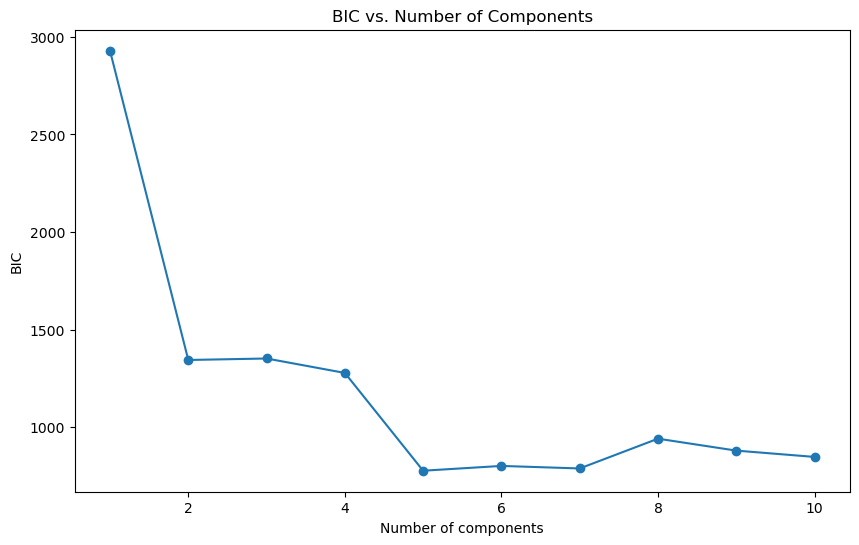

In [20]:
# Example: Determining the optimal number of components using BIC
lowest_bic = np.infty
best_n_components = 1
bic = []
n_components_range = range(1, 11)
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(data_preprocessed)
    bic.append(gmm.bic(data_preprocessed))
    if bic[-1] < lowest_bic:
        lowest_bic = bic[-1]
        best_n_components = n_components

print(f"Optimal number of components: {best_n_components}")
plt.figure(figsize=(10, 6))
plt.plot(n_components_range, bic, marker="o")
plt.xlabel("Number of components")
plt.ylabel("BIC")
plt.title("BIC vs. Number of Components")
plt.show()

### Mean Shift Clustering:
- Description: Finds clusters by shifting points towards the mode (densest part) of a region.
- Use Cases: Image processing, object tracking.
- Pros: No need to specify the number of clusters, can find arbitrarily shaped clusters.
- Cons: Computationally intensive, sensitive to bandwidth parameter.

Hyperparameters:
- bandwidth: The bandwidth parameter.
- Tuning: Use the estimate_bandwidth function from sklearn to determine the optimal bandwidth.

In [21]:
df_msc = df

# Fit the preprocessor to the data and transform it
data_preprocessed = preprocessor.fit_transform(df_msc)

# Perform Mean Shift clustering
meanshift = MeanShift(bandwidth=2.29)
meanshift.fit(data_preprocessed)
labels = meanshift.labels_

# Add the cluster labels to the original data
df_msc["cluster"] = labels

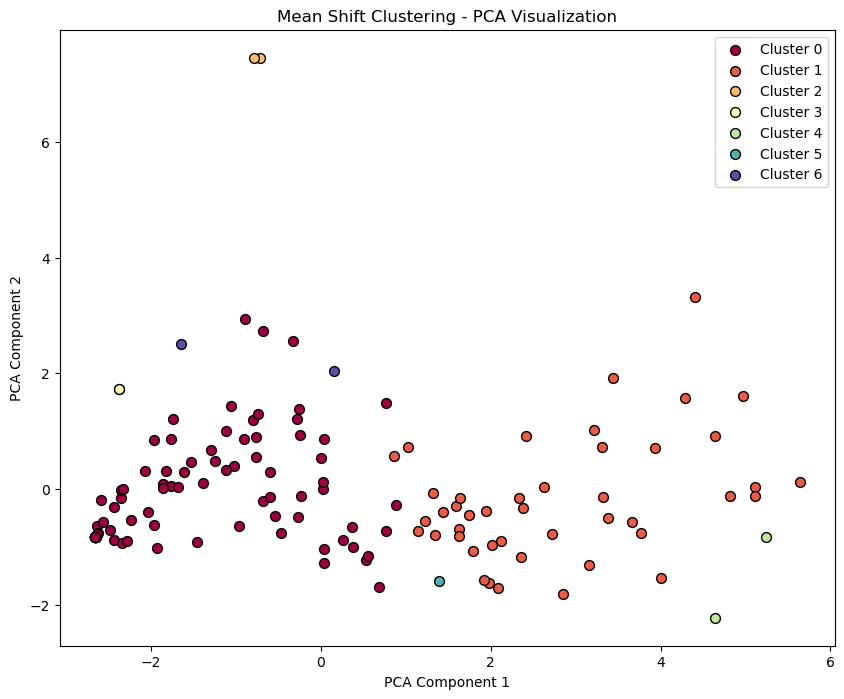

In [26]:
# PCA for 2D visualization
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_preprocessed)

# Plot the resulting clusters
plt.figure(figsize=(10, 8))
unique_labels = set(labels)
colors = [plt.cm.Spectral(each / max(unique_labels)) for each in unique_labels]
for k, col in zip(unique_labels, colors):
    class_member_mask = labels == k
    xy = data_pca[class_member_mask]
    plt.scatter(xy[:, 0], xy[:, 1], c=[col], label=f"Cluster {k}", edgecolor="k", s=50)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Mean Shift Clustering - PCA Visualization")
plt.legend()
plt.show()

In [23]:
df_msc

,Agent,TotalCalls,UsefulCalls,ConnectedCallTimeMins,UsefulCallTimeMins,ConnectedCalls,MedianConnectedCallTime,TotalEmails,Booking,TotalRevenue,AverageTicket,TotalNewLeads,GrossCRLead_per,L2A_per,A2PA_per,PaidApps,AllApps,cluster
0,Adriana Hernandez,214.0,214.0,29.300000,80.316667,9.0,2.600000,257.0,11540.0,11540.0,11540.000000,117,0.854701,14.529915,5.882353,1,17,0
1,Alberto Conde,3159.0,3055.0,1468.833333,2174.333333,205.0,4.066667,3148.0,149103.0,129934.0,8283.500000,1319,1.364670,8.263836,16.513761,18,109,0
2,Alejandra Almonte,3742.0,3737.0,835.833333,1437.683333,215.0,2.983333,2171.0,114173.0,109101.0,2594.840909,1342,3.278689,10.357675,31.654676,44,139,0
3,Amanda Campos,6012.0,5911.0,1397.650000,2470.483333,315.0,3.383333,3937.0,31020.0,23486.0,2068.000000,1916,0.782881,5.584551,14.018692,15,107,0
4,Amanda Da Rosa,449.0,445.0,235.183333,313.683333,54.0,2.833333,13.0,0.0,0.0,0.000000,109,0.000000,7.339450,0.000000,0,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,Veronica Miquilena,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,2,0.000000,0.000000,0.000000,0,0,0
138,Verónica Miquilena,8929.0,8857.0,4049.766667,6431.733333,825.0,3.033333,8.0,341709.0,253494.0,6973.653061,3557,1.377565,4.723081,29.166667,49,168,1
139,Victor Fernandes,6066.0,5999.0,2432.750000,4517.466667,513.0,2.966667,25.0,240254.0,156266.0,15015.875000,2373,0.674252,3.497682,19.277108,16,83,0
140,Wolfang Freites,6783.0,6651.0,2904.733333,4789.350000,480.0,3.766667,5294.0,72799.0,66826.0,2141.147059,2168,1.568266,5.258303,29.824561,34,114,1


In [24]:
# Example: Determining the optimal bandwidth
bandwidth = estimate_bandwidth(data_preprocessed, quantile=0.2)
meanshift = MeanShift(bandwidth=bandwidth)
meanshift.fit(data_preprocessed)

MeanShift(bandwidth=2.2918454824438226)

### Análisis

In [39]:
df_gmm.cluster.value_counts()

cluster
1    46
4    39
2    34
0    21
3     2
Name: count, dtype: int64

<Axes: xlabel='Agent', ylabel='TotalRevenue'>

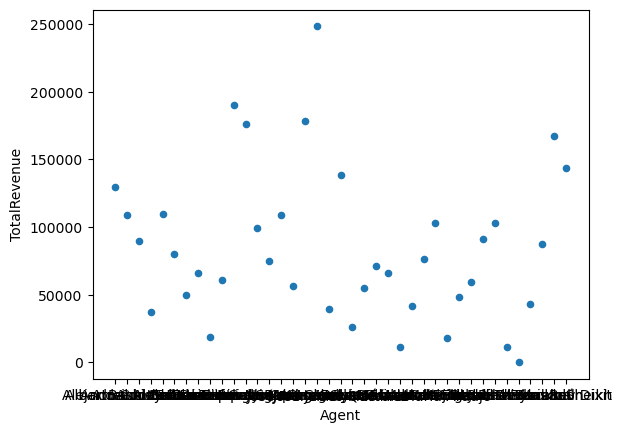

In [65]:
df_gmm.query("cluster == 0").plot.scatter(x="Agent", y="TotalRevenue")